In [1]:
from datetime import datetime, timedelta

nfpTime = datetime(2023,1,6, 21, 29)
cpiTime = datetime(2023,1, 12, 21, 29)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import talib as ta
import mplfinance as mpf

In [4]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance']

client = pymongo.MongoClient('172.16.20.81', 27017)

In [5]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [6]:
dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [7]:
crytoDict = {
                'btc_nfp':readDb(dbClient[symbolList[0]], start=nfpTime , end=nfpTime+timedelta(days=2))[columnsName],
                'eth_nfp':readDb(dbClient[symbolList[1]], start=nfpTime , end=nfpTime+timedelta(days=2))[columnsName],
                'btc_cpi':readDb(dbClient[symbolList[0]], start=cpiTime , end=cpiTime+timedelta(days=2))[columnsName],
                'eth_cpi':readDb(dbClient[symbolList[1]], start=cpiTime , end=cpiTime+timedelta(days=2))[columnsName]
            }

In [8]:
def resampleDf(data, freq='H'):
#     df = data.drop('_id', axis=1)
    dataDf = data.set_index('datetime')
    dataHourDf = dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataHourDf.reset_index()
    return dataResetDf

In [9]:
def addSymbol(dataDf, symbolName):  
    dataDf['symbol'] = symbolName
    return dataDf

In [10]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['datetime', 'symbol'])
    return dataIndex

In [11]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df, '30Min')
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [12]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [13]:
multiDf

open      high       low     close  \
datetime            symbol                                            
2023-01-06 21:30:00 btc_nfp  16688.62  16817.00  16679.00  16774.19   
                    eth_nfp   1238.62   1253.80   1236.00   1250.42   
2023-01-06 22:00:00 btc_nfp  16774.19  16782.66  16744.27  16762.26   
                    eth_nfp   1250.42   1251.46   1248.02   1250.54   
2023-01-06 22:30:00 btc_nfp  16762.26  16791.49  16720.00  16748.82   
...                               ...       ...       ...       ...   
2023-01-14 20:00:00 eth_cpi   1530.08   1533.46   1520.59   1532.98   
2023-01-14 20:30:00 btc_cpi  20720.66  20975.00  20716.41  20911.19   
                    eth_cpi   1532.98   1546.88   1532.11   1538.67   
2023-01-14 21:00:00 btc_cpi  20911.19  20944.99  20782.86  20858.32   
                    eth_cpi   1538.68   1540.28   1531.72   1532.65   

                                  volume  
datetime            symbol                
2023-01-06 21:30:00 btc_nfp  12847.53718  
                    eth_nfp  42364.14380  
2023-01-06 22:00:00 btc_nfp   4401.26829  
                    eth_nfp   5336.79100  
2023-01-06 22:30:00 btc_nfp   6564.50880  
...                                  ...  
2023-01-14 20:00:00 eth_cpi  11630.82170  
2023-01-14 20:30:00 btc_cpi  10720.67568  
                    eth_cpi  19706.77310  
2023-01-14 21:00:00 btc_cpi   6117.31022  
                    eth_cpi   9729.27460  

[384 rows x 5 columns]

In [14]:
nfpData = pd.read_excel('nfp.xlsx')
nfpDf = nfpData.sort_index(ascending=False).iloc[:-1]
nfpDf['ActualNum'] = list(map(lambda an: int(an[:-1]), nfpDf['Actual']))
nfpDf['ForecastNum'] = list(map(lambda fn: int(fn[:-1]), nfpDf['Forecast']))

In [15]:
nfpDf

,Release Date,Time,Actual,Forecast,Previous,Unnamed: 5,ActualNum,ForecastNum
11,"Mar 04, 2022 (Feb)",08:30:00,678K,400K,481K,NaN,678,400
10,"Apr 01, 2022 (Mar)",07:30:00,431K,490K,750K,NaN,431,490
9,"May 06, 2022 (Apr)",07:30:00,428K,391K,428K,NaN,428,391
8,"Jun 03, 2022 (May)",07:30:00,390K,325K,436K,NaN,390,325
7,"Jul 08, 2022 (Jun)",07:30:00,372K,268K,384K,NaN,372,268
6,"Aug 05, 2022 (Jul)",07:30:00,528K,250K,398K,NaN,528,250
5,"Sep 02, 2022 (Aug)",07:30:00,315K,300K,526K,NaN,315,300
4,"Oct 07, 2022 (Sep)",07:30:00,263K,250K,315K,NaN,263,250
3,"Nov 04, 2022 (Oct)",07:30:00,261K,200K,315K,NaN,261,200
2,"Dec 02, 2022 (Nov)",08:30:00,263K,200K,284K,NaN,263,200


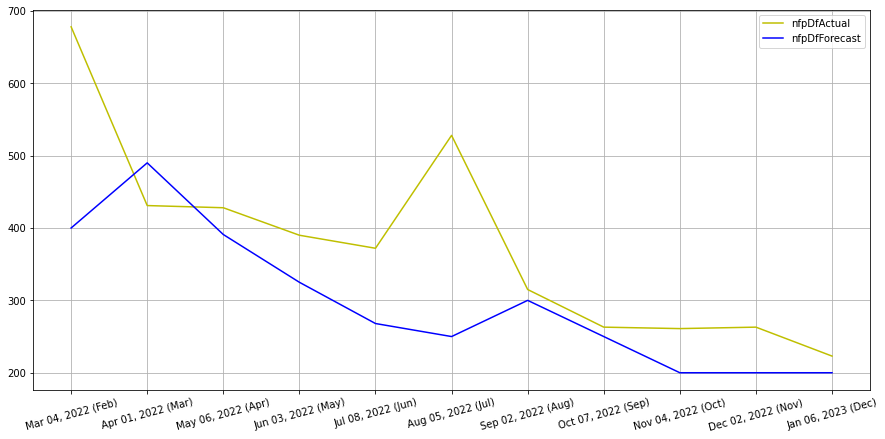

In [16]:
plt.figure(figsize=(15, 7))
plt.plot(nfpDf['Release Date'], nfpDf['ActualNum'], label='nfpDfActual', color='y')
plt.plot(nfpDf['Release Date'], nfpDf['ForecastNum'], label='nfpDfForecast', color='b')
plt.legend()
plt.grid()
plt.xticks(rotation=15)
plt.savefig('nfpData')
plt.show()

In [17]:
cpiData = pd.read_excel('cpi.xlsx')
cpiDf = cpiData.sort_index(ascending=False).iloc[:-1]

In [18]:
cpiDf

,Release Date,Time,Actual,Forecast,Previous,Unnamed: 5
11,"Mar 10, 2022 (Feb)",08:30:00,0.005,0.005,0.006,NaN
10,"Apr 12, 2022 (Mar)",07:30:00,0.003,0.005,0.005,NaN
9,"May 11, 2022 (Apr)",07:30:00,0.006,0.004,0.003,NaN
8,"Jun 10, 2022 (May)",07:30:00,0.006,0.005,0.006,NaN
7,"Jul 13, 2022 (Jun)",07:30:00,0.007,0.006,0.006,NaN
6,"Aug 10, 2022 (Jul)",07:30:00,0.003,0.005,0.007,NaN
5,"Sep 13, 2022 (Aug)",07:30:00,0.006,0.003,0.003,NaN
4,"Oct 13, 2022 (Sep)",07:30:00,0.006,0.005,0.006,NaN
3,"Nov 10, 2022 (Oct)",08:30:00,0.003,0.005,0.006,NaN
2,"Dec 13, 2022 (Nov)",08:30:00,0.002,0.003,0.003,NaN


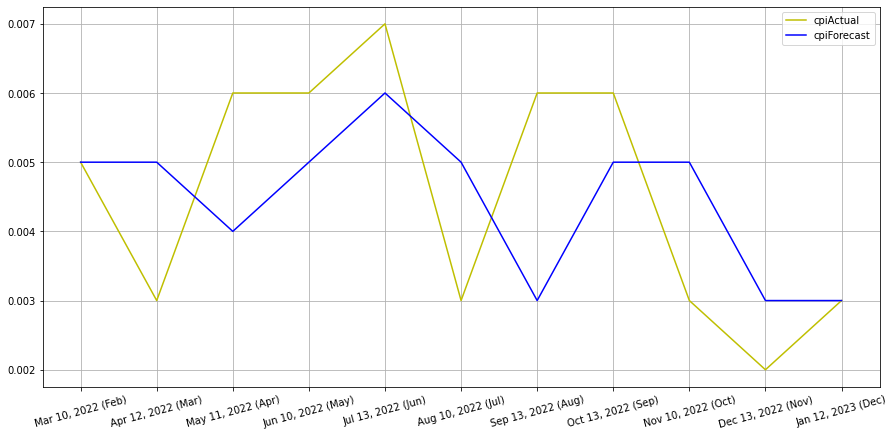

In [19]:
plt.figure(figsize=(15, 7))
plt.plot(cpiDf['Release Date'], cpiDf['Actual'], label='cpiActual', color='y')
plt.plot(cpiDf['Release Date'], cpiDf['Forecast'], label='cpiForecast', color='b')
plt.legend()
plt.grid()
plt.xticks(rotation=15)
plt.savefig('cpiData')
plt.show()

In [20]:
btc_nfp = multiDf.loc[:, pd.IndexSlice['btc_nfp'], :]
btc_cpi = multiDf.loc[:, pd.IndexSlice['btc_cpi'], :]
eth_nfp = multiDf.loc[:, pd.IndexSlice['eth_nfp'], :]
eth_cpi = multiDf.loc[:, pd.IndexSlice['eth_cpi'], :]

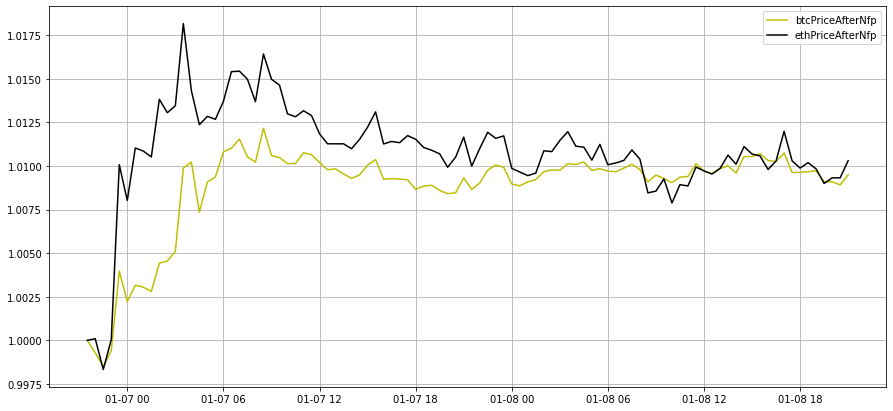

In [21]:
plt.figure(figsize=(15, 7))
plt.plot(btc_nfp.close/btc_nfp.close[0], label='btcPriceAfterNfp', color='y')
plt.plot(eth_nfp.close/eth_nfp.close[0], label='ethPriceAfterNfp', color='black')
plt.legend()
plt.grid()
plt.savefig('priceAfterNfp')
plt.show()

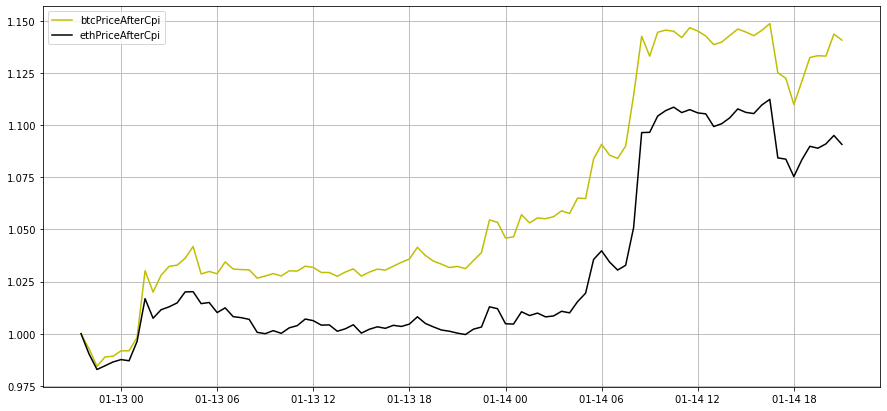

In [22]:
plt.figure(figsize=(15, 7))
plt.plot(btc_cpi.close/btc_cpi.close[0], label='btcPriceAfterCpi', color='y')
plt.plot(eth_cpi.close/eth_cpi.close[0], label='ethPriceAfterCpi', color='black')
plt.legend()
plt.grid()
plt.savefig('priceAfterCpi')
plt.show()

In [23]:
btc_nfp.close[-1]/btc_nfp.close[0]

1.0094901750844603

In [24]:
nfpBtcPct = (btc_nfp.close[-1]/btc_nfp.close[0]-1)*100
nfpEthPct = (eth_nfp.close[-1]/eth_nfp.close[0]-1)*100
nfpEvent = pd.DataFrame({'nfpJan2023': ('nfpActual', 'nfpForecast', 'after2DayBtcPct', 'after2DayEthPct'),
'nfpEffect': (nfpDf['Actual'].iloc[-1], nfpDf['Forecast'].iloc[-1], str(round(nfpBtcPct, 2))+"%", str(round(nfpEthPct, 2))+"%")
})

In [25]:
nfpEventT = nfpEvent.set_index('nfpJan2023').T

In [26]:
cpiBtcPct = (btc_cpi.close[-1]/btc_cpi.close[0]-1)*100
cpiEthPct = (eth_cpi.close[-1]/eth_cpi.close[0]-1)*100
cpiEvent = pd.DataFrame({'cpiJan2023': ('cpiActual', 'cpiForecast', 'after2DayBtcPct', 'afterTwoDayEthPct'),
'cpiEffect': (cpiDf['Actual'].iloc[-1], cpiDf['Forecast'].iloc[-1], str(round(cpiBtcPct, 2))+"%", str(round(cpiEthPct, 2))+"%", )
})

In [27]:
cpiEventT = cpiEvent.set_index('cpiJan2023').T

In [28]:
nfpEventT.to_excel('nfpEvent.xlsx')
cpiEventT.to_excel('cpiEvent.xlsx')

In [29]:
cpiEventT

cpiJan2023,cpiActual,cpiForecast,after2DayBtcPct,afterTwoDayEthPct
cpiEffect,0.003,0.003,14.07%,9.07%
